<a href="https://colab.research.google.com/github/imrealhelper/Linear-Algebra/blob/main/trajectory_optmization_under_nonconvex_constraints_Jinwoo_IM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Trajectory optimization under nonconvex constraints


$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE7030: Convex Optimization, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

---



We'll consider optimal vehicle guidance problem with position $p_t\in\R^2$, velocity $v_t\in\R^2$. The vehicle's control force $u_t\in\R^2$ is acceleration control for the two axes.

<br>

The dynamics is governed by

$$
\begin{aligned}
  \dot{v} &= u - \gamma v  \\
  \dot{p} &= v  
\end{aligned}
$$

where a small constant $\gamma$ is the friction (or damping) coefficient. Trapezoidal integration assuming constant acceleration during the sampling interval gives following,

$$
\begin{aligned}
  v_{t+1} &= v_t + {\Delta t}\left( u_t - \gamma v_t  \right) \\
  &= \left(1-\gamma \Delta t\right) v_t + \Delta t u_t \\
  p_{t+1} &= p_t + 0.5{\Delta t}\left( v_t + v_{t+1} \right)  \\
  &= p_t + 0.5{\Delta t}\left( v_t + \left(1-\gamma \Delta t\right) v_t + \Delta t u_t \right)  \\
  &= p_t +  \left(\Delta t-0.5\gamma\Delta t^2\right) v_t + 0.5 \Delta t^2 u_t
\end{aligned}
$$

and the minimum energy trajectory optimization problem can be formulated as follows.

$$
\begin{aligned}
  \underset{u_t, v_t, p_t}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to}
  \quad & v_{t+1} = \left(1-\gamma \Delta t\right) v_t + \Delta t u_t \\
  \quad & p_{t+1} = p_t +  \left(\Delta t-0.5\gamma\Delta t^2\right) v_t + 0.5 \Delta t^2 u_t \\
  \quad & v_N = v_\text{des} \\
  \quad & p_N = p_\text{des}
\end{aligned}
$$

<br>

We consider the finite horizon of $T=50$, and $\Delta t=0.1$, with the following data.

In [175]:
import numpy as np
import matplotlib.pyplot as plt

N = 500
T = 50
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping

p_0   = np.array([ 10, -20])
v_0   = np.array([ 15,  -5])
p_des = np.array([100,  50])
v_des = np.array([  0,   0])

<br>

---

## Minimum energy control with state and control limits

Suppose your vehicle is subjecteed to move inside a rectangular area with limited maneuver acceleration. It is like your robot vaccum searching for the minimum energy trajectory inside your (rectangular) room.

The constrained trajectory optimization problem can be described by

$$
\begin{aligned}
  \underset{u_t, v_t, p_t}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to}
  \quad & v_{t+1} = \left(1-\gamma \Delta t\right) v_t + \Delta t u_t \\
  \quad & p_{t+1} = p_t +  \left(\Delta t-0.5\gamma\Delta t^2\right) v_t + 0.5 \Delta t^2 u_t \\
  \quad & v_N = v_\text{des} \\
  \quad & p_N = p_\text{des} \\
  & p_\text{lb} \le p_t \le p_\text{ub} \\
  & \| u_t \| \le u_\text{ub}
\end{aligned}
$$

where $p_\text{lb}$ and $p_\text{ub}$ describe the boundary of the rectangle and $u_\text{ub}$ is the upper bound of the maneuver acceleration.


In [176]:
import cvxpy as cp

###########################
p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
u_ub = 1.0
###########################

p = cp.Variable((2,N+1))  # p_{0},...,p_{N}
v = cp.Variable((2,N+1))  # v_{0},...,v_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = cp.Minimize(cp.sum_squares(u))

constr  = [ p[:,-1] == p_des,  p[:,0] == p_0 ]
constr += [ v[:,-1] == v_des,  v[:,0] == v_0 ]
for t in range(N):
    constr += [ v[:,t+1] == (1-gamma*delt)*v[:,t] + delt*u[:,t] ]
    constr += [ p[:,t+1] == p[:,t] + delt*(1-0.5*gamma*delt)*v[:,t]
                + 0.5*delt**2*u[:,t] ]
    ################################################
    constr += [ p_lb <= p[:,t+1], p[:,t+1] <= p_ub ]
    constr += [ cp.norm(u[:,t]) <= u_ub ]
    ################################################

cp.Problem(obj, constr).solve(verbose=True)

p_cp = np.array(p.value)
v_cp = np.array(p.value)
u_cp = np.array(u.value)

                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 03 12:27:05 PM: Your problem has 3004 variables, 4508 constraints, and 0 parameters.
(CVXPY) Apr 03 12:27:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 03 12:27:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 03 12:27:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 03 12:27:06 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 03 12:27:06 PM: Compiling problem (target solver=CLARAB

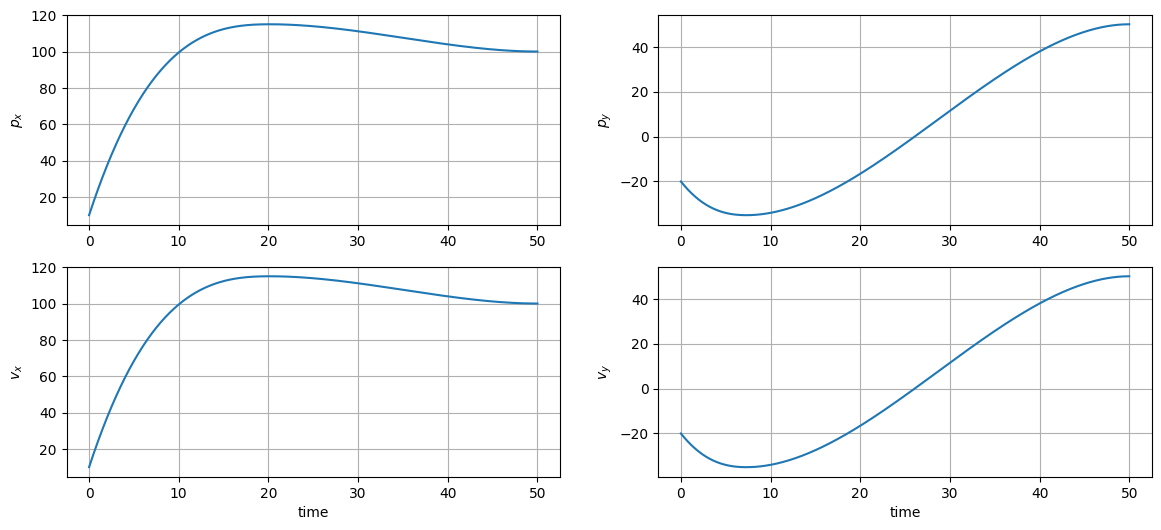

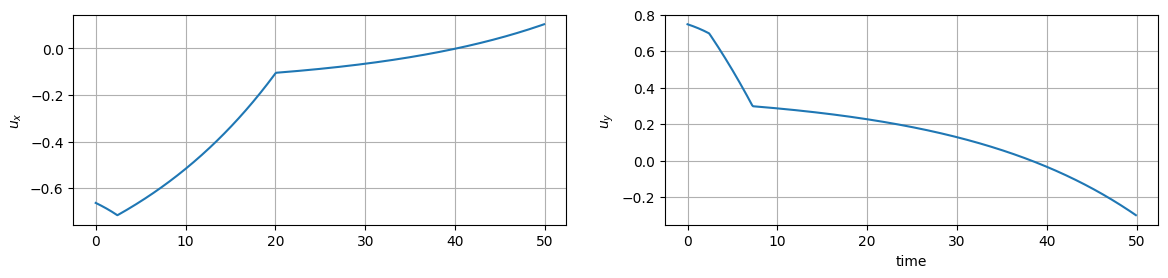

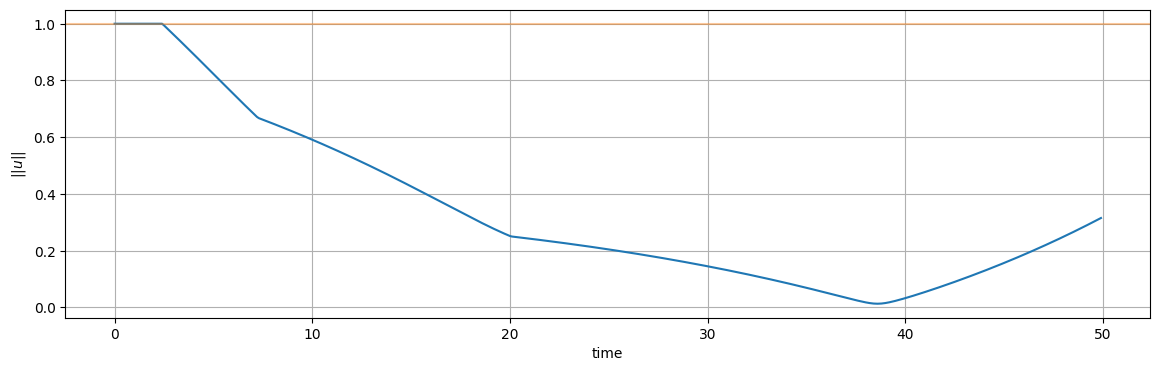

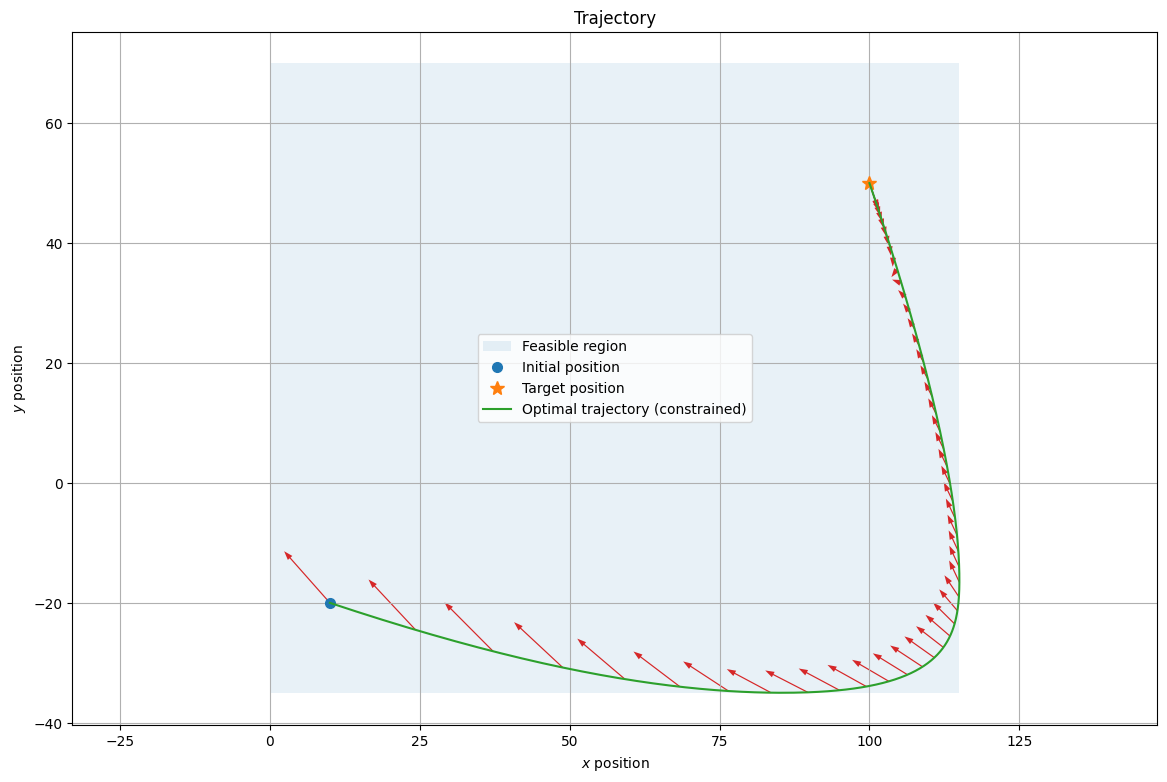

In [177]:
plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,p_cp[0,:])
plt.ylabel(r'$p_x$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,p_cp[1,:])
plt.ylabel(r'$p_y$')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,v_cp[0,:])
plt.xlabel('time')
plt.ylabel(r'$v_x$')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,v_cp[1,:])
plt.xlabel('time')
plt.ylabel(r'$v_y$')
plt.grid()
plt.show()

plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_cp[0,:])
plt.ylabel(r'$u_x$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_cp[1,:])
plt.xlabel('time')
plt.ylabel(r'$u_y$')
plt.grid()
plt.show()
plt.figure(figsize=(14,4), dpi=100)
plt.plot(ts[:-1],np.linalg.norm(u_cp,axis=0))
plt.axhline(u_ub, color=plt.cm.tab20(2), alpha=0.4, label=r'$u_{ub}$')
plt.xlabel('time')
plt.ylabel(r'$||u||$')
plt.grid()
plt.show()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.plot(p_0[0], p_0[1], 'o', markersize=7, label='Initial position')
plt.plot(p_des[0], p_des[1], '*', markersize=10, label='Target position')
plt.plot(p_cp[0,:],p_cp[1,:], label='Optimal trajectory (constrained)')
plt.title('Trajectory')
plt.legend()
for i in range(0,N-1,10):
  plt.arrow(p_cp[0,i], p_cp[1,i], 10*u_cp[0,i], 10*u_cp[1,i], \
            head_width=1.0, width=0.2, fc='tab:red', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

<br>

---

## Minimum energy control with nonconvex constraints

In addition to the previous constraints we add the following two nonconvex constraints:

* The trajectory should maintain the safety distance of $d_\text{sft}$ from the center $p_\text{obs}$.  
* The control should be always larger than $u_\text{lb}$ (some actuators require this).

So the problem can be described by

$$
\begin{aligned}
  \underset{u_t, v_t, p_t}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to}
  \quad & v_{t+1} = \left(1-\gamma \Delta t\right) v_t + \Delta t u_t \\
  \quad & p_{t+1} = p_t +  \left(\Delta t-0.5\gamma\Delta t^2\right) v_t + 0.5 \Delta t^2 u_t \\
  \quad & v_N = v_\text{des} \\
  \quad & p_N = p_\text{des} \\
  & p_\text{lb} \le p_t \le p_\text{ub} \\
  & \| p_t - p_\text{obs} \| \ge d_\text{sft} \\
  & u_\text{lb} \le \| u_t \| \le u_\text{ub}
\end{aligned}
$$

<br>

Note that the last two nonconvex constraints can be linearized along the reference trajectory $\bar{p}$ and $\bar{u}$ as follows.

\begin{equation}
\| p_t - p_\text{obs} \| \ge d_\text{sft} \quad \Longrightarrow \quad
2\left(\bar{p}_t - p_\text{obs}\right)^T p_t \ge d_\text{sft}^2 + \|\bar{p}_t\|^2 - \|{p_\text{obs}}\|^2
\end{equation}

\begin{equation}
\| u_t \| \ge u_\text{lb} \quad \Longrightarrow \quad
2\bar{u}_t^T u_t \ge u_\text{lb}^2 + \|\bar{u}_t\|^2
\end{equation}

<br>

The following sequential convex programming procedures can handle the above nonconvex problem.

1. Set $k=0$ and find the initial reference trajectory, $\left( u^{(k)}, v^{(k)}, p^{(k)}\right)$, for the problem _without_ the nonconvex constraints.

2. Linearize (or convexify) the nonconvex constraints along the previously obtained reference trajectory, $\left( u^{(k)}, v^{(k)}, p^{(k)}\right)$.

3. Find the reference trajectory, $\left( u^{(k+1)}, v^{(k+1)}, p^{(k+1)}\right)$, for the problem with the linearzed constraints obtained from 2.

4. Terminate if $\left( u^{(k+1)}, v^{(k+1)}, p^{(k+1)}\right)$ and $\left( u^{(k)}, v^{(k)}, p^{(k)}\right)$ are close enough. Otherwise, set $k=k+1$ and go to 2.

In [178]:
p_cp_hist = []
v_cp_hist = []
u_cp_hist = []

p = cp.Variable((2,N+1))  # p_{0},...,p_{N}
v = cp.Variable((2,N+1))  # v_{0},...,v_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = cp.Minimize(cp.sum_squares(u))

constr  = [ p[:,-1] == p_des,  p[:,0] == p_0 ]
constr += [ v[:,-1] == v_des,  v[:,0] == v_0 ]
for t in range(N):
    constr += [ v[:,t+1] == (1-gamma*delt)*v[:,t] + delt*u[:,t] ]
    constr += [ p[:,t+1] == p[:,t] + delt*(1-0.5*gamma*delt)*v[:,t]
                + 0.5*delt**2*u[:,t] ]
    constr += [ p_lb <= p[:,t+1], p[:,t+1] <= p_ub ]
    constr += [ cp.norm(u[:,t]) <= u_ub ]

cp.Problem(obj, constr).solve(verbose=True)

p_cp = np.array(p.value)
v_cp = np.array(v.value)
u_cp = np.array(u.value)

p_cp_hist.append(p_cp)
v_cp_hist.append(v_cp)
u_cp_hist.append(u_cp)

                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 03 12:27:12 PM: Your problem has 3004 variables, 4508 constraints, and 0 parameters.
(CVXPY) Apr 03 12:27:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 03 12:27:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 03 12:27:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 03 12:27:12 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 03 12:27:13 PM: Compiling problem (target solver=CLARAB

In [179]:
max_iters = 10

##########################
p_obs = np.array([120,20])
d_sft = 20
u_lb = 0.1
##########################

for iter in range(max_iters):

  p0 = p_cp
  v0 = v_cp
  u0 = u_cp

  obj = cp.Minimize(cp.sum_squares(u))

  constr  = [ p[:,-1] == p_des,  p[:,0] == p_0 ]
  constr += [ v[:,-1] == v_des,  v[:,0] == v_0 ]
  for t in range(N):
    constr += [ v[:,t+1] == (1-gamma*delt)*v[:,t] + delt*u[:,t] ]
    constr += [ p[:,t+1] == p[:,t] + delt*(1-0.5*gamma*delt)*v[:,t]
                + 0.5*delt**2*u[:,t] ]
    constr += [ p_lb <= p[:,t+1], p[:,t+1] <= p_ub ]
    constr += [ cp.norm(u[:,t]) <= u_ub ]
    ##################################################################
    constr += [ 2*(p0[:,t] - p_obs).T@p[:,t] >= d_sft**2
               + cp.sum_squares(p0[:,t]) - p_obs.dot(p_obs) ]
    constr += [ 2*u0[:,t].T@u[:,t] >= u_lb**2 + u0[:,t].dot(u0[:,t]) ]
    ##################################################################

  cp.Problem(obj, constr).solve(verbose=False)

  p_cp = p.value
  v_cp = v.value
  u_cp = u.value

  p_cp_hist.append(p_cp)
  v_cp_hist.append(v_cp)
  u_cp_hist.append(u_cp)

  print(iter)
  if (np.linalg.norm(p_cp_hist[-1]-p_cp_hist[-2],'fro')<1.0):
    n_iters = len(p_cp_hist)
    print(f'terminated after {iter+1} iterations')
    break


0
1
2
3
4
terminated after 5 iterations


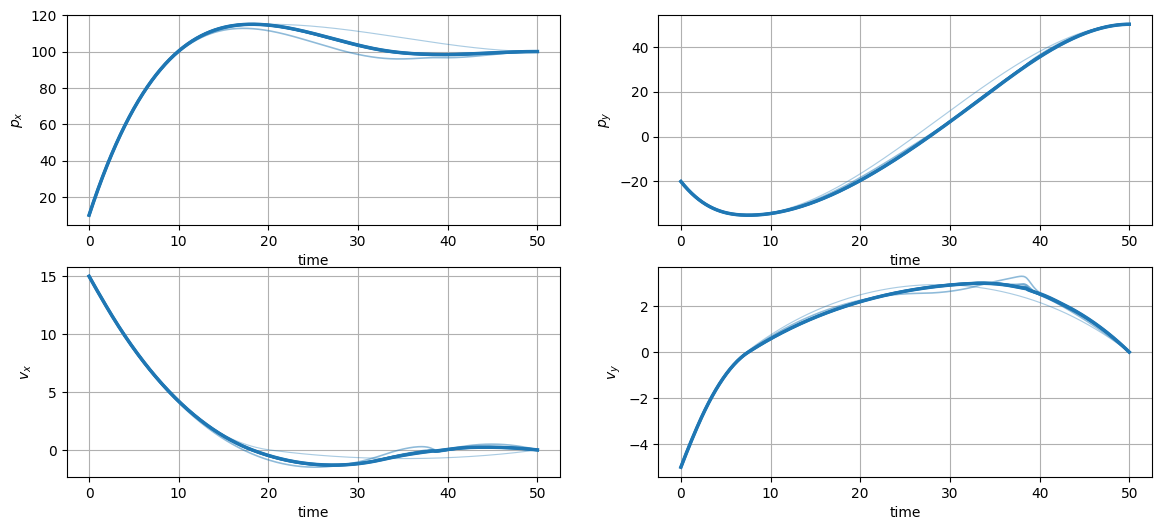

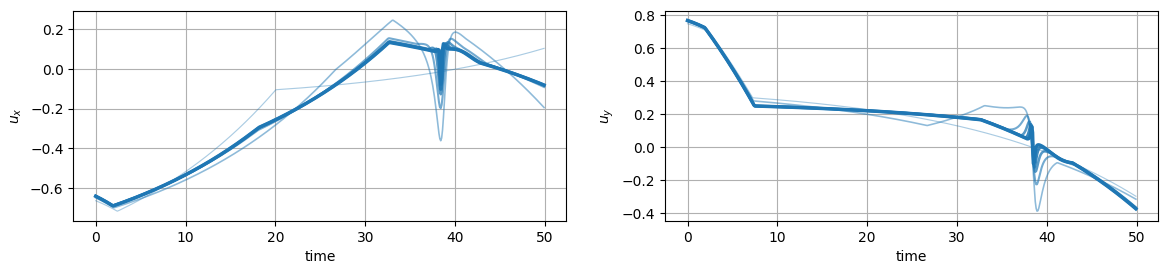

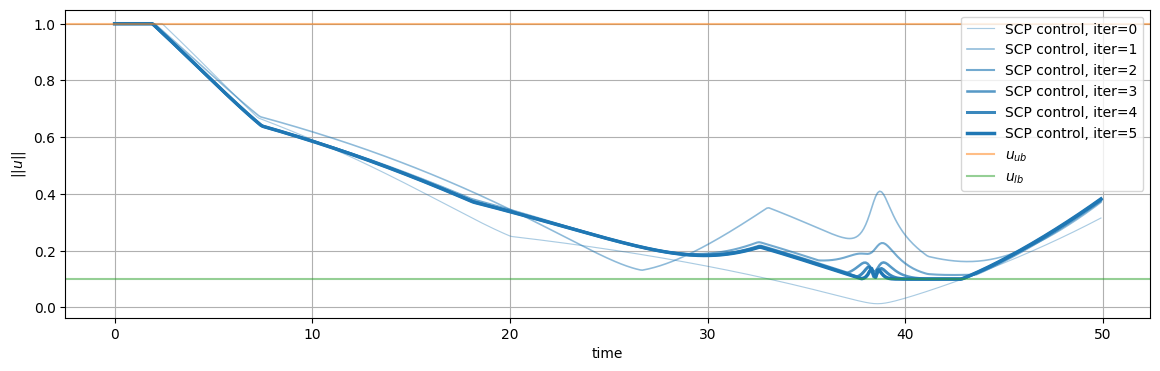

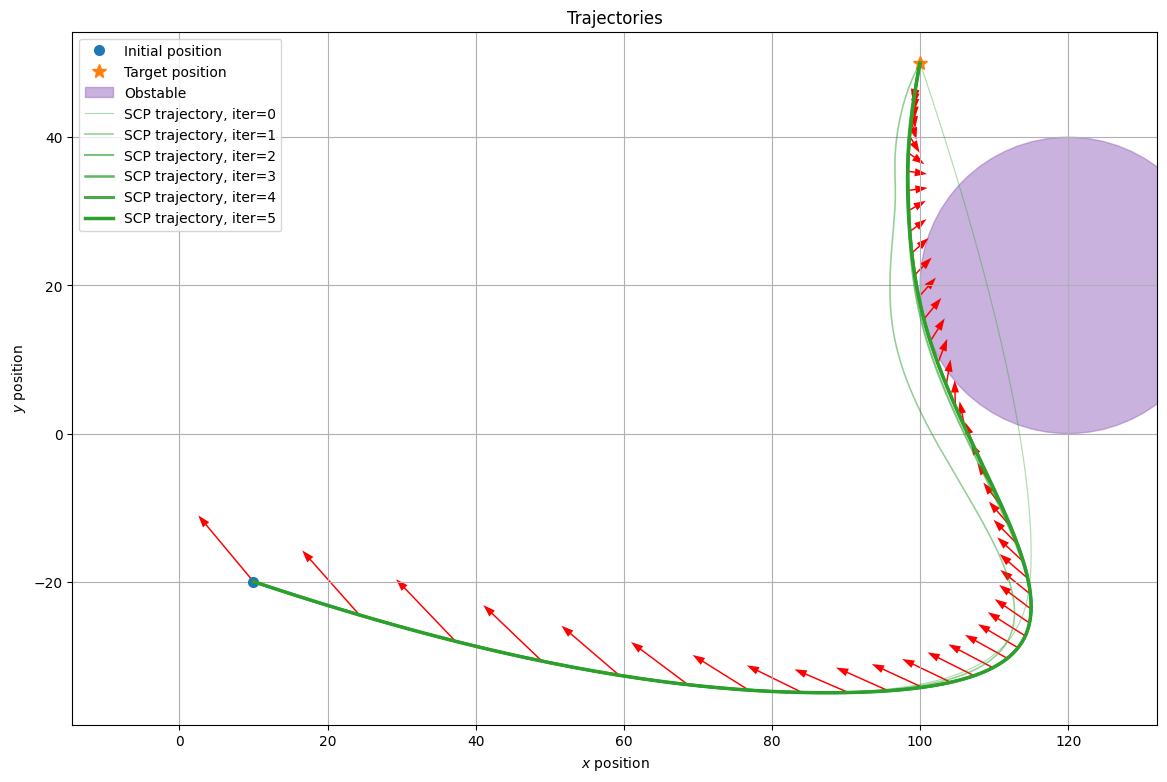

In [180]:
plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
for id in range(n_iters):
  plt.plot(ts,p_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$p_x$')
plt.grid()
plt.subplot(2,2,2)
for id in range(n_iters):
  plt.plot(ts,p_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$p_y$')
plt.grid()
plt.subplot(2,2,3)
for id in range(n_iters):
  plt.plot(ts,v_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$v_x$')
plt.grid()
plt.subplot(2,2,4)
for id in range(n_iters):
  plt.plot(ts,v_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$v_y$')
plt.grid()
plt.show()

plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
for id in range(n_iters):
  plt.plot(ts[:-1],u_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$u_x$')
plt.grid()
plt.subplot(2,2,2)
for id in range(n_iters):
  plt.plot(ts[:-1],u_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$u_y$')
plt.grid()
plt.show()
plt.figure(figsize=(14,4), dpi=100)
for id in range(n_iters):
  plt.plot(ts[:-1],np.linalg.norm(u_cp_hist[id],axis=0), \
           color=plt.cm.tab20(0), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP control, iter={id}')
plt.xlabel('time')
plt.ylabel(r'$||u||$')
plt.axhline(u_ub, color=plt.cm.tab20(2), alpha=0.5, label=r'$u_{ub}$')
plt.axhline(u_lb, color=plt.cm.tab20(4), alpha=0.5, label=r'$u_{lb}$')
plt.legend()
plt.grid()
plt.show()

axes = plt.figure(num=1, figsize=(14,9), dpi=100)

plt.plot(p_0[0], p_0[1], 'o', markersize=7, label='Initial position')
plt.plot(p_des[0], p_des[1], '*', markersize=10, label='Target position')
plt.gca().add_artist(plt.Circle((p_obs[0],p_obs[1]),d_sft, label='Obstable', \
                                color=plt.cm.tab20(8), alpha=0.5))
for id in range(n_iters):
  plt.plot(p_cp_hist[id][0,:], p_cp_hist[id][1,:], \
           color=plt.cm.tab20(4), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP trajectory, iter={id}')

plt.legend()
plt.title('Trajectories')

for t in range(0,N,10):
  plt.arrow(p_cp_hist[id][0,t], p_cp_hist[id][1,t], \
            10*u_cp_hist[id][0,t], 10*u_cp_hist[id][1,t], \
            head_width=1.1, width=0.2, color='r', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

In [181]:
epsilon = 1e-1

active_labels = []
for t in range(N):

    lhs_p = 2 * (p0[:, t] - p_obs).T @ p_cp[:, t]
    rhs_p = d_sft**2 + np.sum(p0[:, t]**2) - np.sum(p_obs**2)


    lhs_u = 2 * (u0[:, t].T @ u_cp[:, t])
    rhs_u = u_lb**2 + np.sum(u0[:, t]**2)

    active_p = np.abs(lhs_p - rhs_p) < d_sft + 3
    active_u = np.abs(lhs_u - rhs_u) < epsilon

    active_labels.append({
        'time_step': t,
        'safety_constraint_active': active_p,
        'control_lb_constraint_active': active_u
    })


# active_labels에는 각 t마다 두 제약 조건의 활성 여부가 저장됩니다.

In [182]:
active_labels

[{'time_step': 0,
  'safety_constraint_active': np.False_,
  'control_lb_constraint_active': np.False_},
 {'time_step': 1,
  'safety_constraint_active': np.False_,
  'control_lb_constraint_active': np.False_},
 {'time_step': 2,
  'safety_constraint_active': np.False_,
  'control_lb_constraint_active': np.False_},
 {'time_step': 3,
  'safety_constraint_active': np.False_,
  'control_lb_constraint_active': np.False_},
 {'time_step': 4,
  'safety_constraint_active': np.False_,
  'control_lb_constraint_active': np.False_},
 {'time_step': 5,
  'safety_constraint_active': np.False_,
  'control_lb_constraint_active': np.False_},
 {'time_step': 6,
  'safety_constraint_active': np.False_,
  'control_lb_constraint_active': np.False_},
 {'time_step': 7,
  'safety_constraint_active': np.False_,
  'control_lb_constraint_active': np.False_},
 {'time_step': 8,
  'safety_constraint_active': np.False_,
  'control_lb_constraint_active': np.False_},
 {'time_step': 9,
  'safety_constraint_active': np.Fals

In [ ]:
active_labels

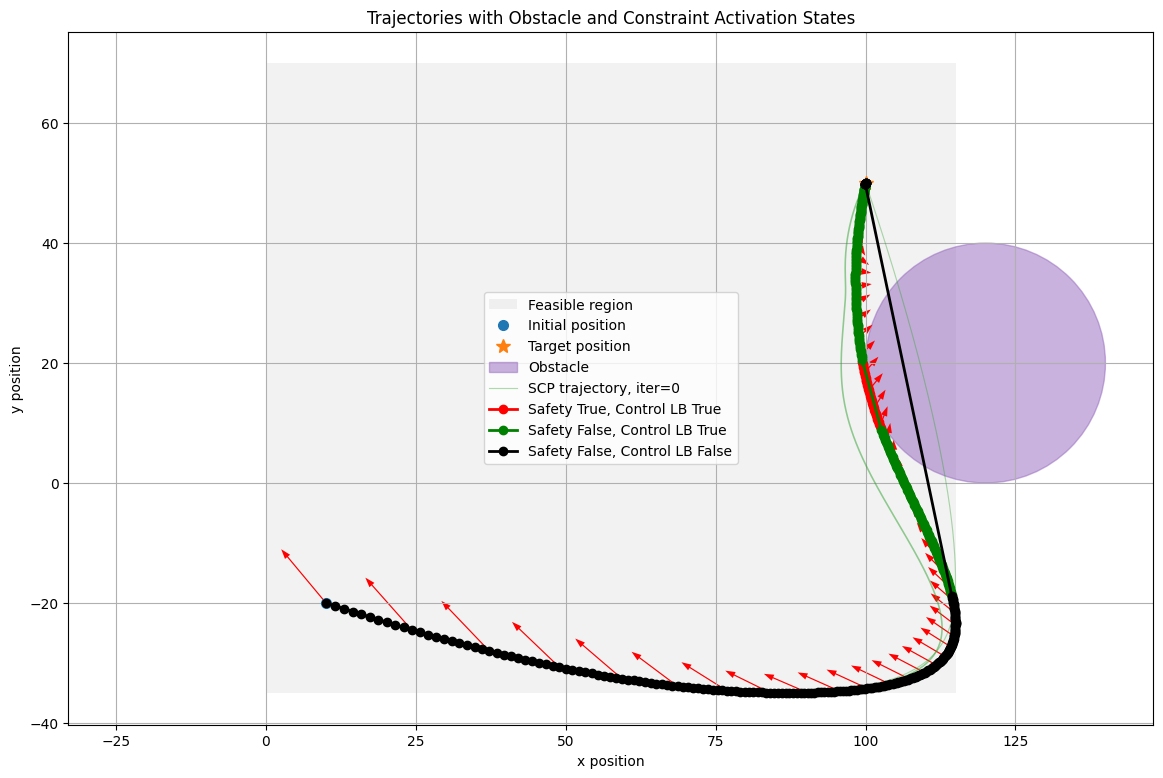

In [183]:

p_trajectory = p_cp_hist[-1]  # shape: (2, N)

state_colors = {
    (True, True): 'red',       # 안전 제약 활성, 제어 하한 제약 활성
    (True, False): 'blue',     # 안전 제약 활성, 제어 하한 제약 비활성
    (False, True): 'green',    # 안전 제약 비활성, 제어 하한 제약 활성
    (False, False): 'black'    # 안전 제약 비활성, 제어 하한 제약 비활성
}

state_labels = {
    (True, True): 'Safety True, Control LB True',
    (True, False): 'Safety True, Control LB False',
    (False, True): 'Safety False, Control LB True',
    (False, False): 'Safety False, Control LB False'
}


trajectories_by_state = {key: {'x': [], 'y': []} for key in state_colors.keys()}
N =  len(active_labels)
for t in range(N):
    state_key = (active_labels[t]['safety_constraint_active'],
                 active_labels[t]['control_lb_constraint_active'])
    trajectories_by_state[state_key]['x'].append(p_trajectory[0, t])
    trajectories_by_state[state_key]['y'].append(p_trajectory[1, t])


plt.figure(figsize=(14,9), dpi=100)


plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]),
                facecolors='gray', alpha=0.1, label='Feasible region')


plt.plot(p_0[0], p_0[1], 'o', markersize=7, label='Initial position')
plt.plot(p_des[0], p_des[1], '*', markersize=10, label='Target position')

# 3. 장애물 표시 (원으로)
obstacle = plt.Circle((p_obs[0], p_obs[1]), d_sft, color=plt.cm.tab20(8),
                      alpha=0.5, label='Obstacle')
plt.gca().add_artist(obstacle)

for id in range(n_iters):
    plt.plot(p_cp_hist[id][0, :], p_cp_hist[id][1, :],
             color=plt.cm.tab20(4),
             linewidth=0.5 + (id+1)/n_iters*2,
             alpha=(id+1+2)/(n_iters+2),
             label=f'SCP trajectory, iter={id}' if id == 0 else None)


for key, traj in trajectories_by_state.items():
    if len(traj['x']) > 0:
        plt.plot(traj['x'], traj['y'], 'o-', color=state_colors[key],
                 linewidth=2, label=state_labels[key])


for t in range(0, N, 10):
    plt.arrow(p_trajectory[0, t], p_trajectory[1, t],
              10 * u_cp_hist[-1][0, t], 10 * u_cp_hist[-1][1, t],
              head_width=1.1, width=0.2, color='r', ec='none')

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Trajectories with Obstacle and Constraint Activation States')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()



                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 03 12:27:51 PM: Your problem has 3004 variables, 4831 constraints, and 0 parameters.
(CVXPY) Apr 03 12:27:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 03 12:27:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 03 12:27:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 03 12:27:51 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 03 12:27:51 PM: Compiling problem (target solver=CLARAB

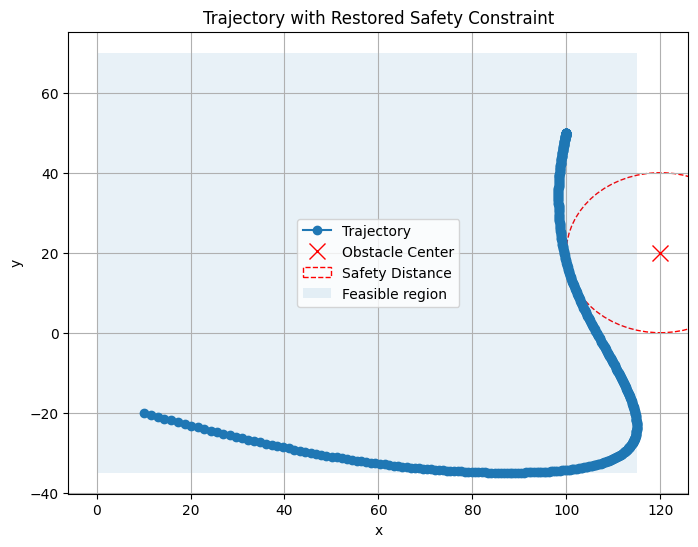

In [184]:
##MAKE_DATA





import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt


p = cp.Variable((2, N+1))
v = cp.Variable((2, N+1))
u = cp.Variable((2, N))








obj = cp.Minimize(cp.sum_squares(u))
constr = [ p[:, 0] == p_0, p[:, -1] == p_des,
           v[:, 0] == v_0, v[:, -1] == v_des ]

for t in range(N):
    constr += [ v[:, t+1] == (1 - gamma*delt)*v[:, t] + delt*u[:, t] ]
    constr += [ p[:, t+1] == p[:, t] + delt*(1 - 0.5*gamma*delt)*v[:, t] + 0.5*delt**2*u[:, t] ]
    constr += [ p_lb <= p[:, t+1], p[:, t+1] <= p_ub ]
    constr += [ cp.norm(u[:, t]) <= u_ub ]

    # safety constraint 복원: 해당 시간 단계의 active_labels가 True인 경우 선형화된 형태로 추가
    if active_labels[t]['safety_constraint_active']:
        # 선형화된 safety constraint:
        constr += [ 2*(p0[:, t] - p_obs).T @ p[:, t] >= d_sft**2 + np.sum(p0[:, t]**2) - np.sum(p_obs**2) ]
    if active_labels[t]['control_lb_constraint_active']:
        constr += [ 2*u0[:,t].T@u[:,t] >= u_lb**2 + u0[:,t].dot(u0[:,t]) ]


    # 만약 비활성이면 안전 거리 제약은 생략하여 자유롭게 궤적이 형성되도록 함

# 문제 해결
prob = cp.Problem(obj, constr)
prob.solve(verbose=True)

# 최적화 결과 궤적
p_sol = p.value
v_sol = v.value
u_sol = u.value

# 궤적 시각화
plt.figure(figsize=(8, 6))
plt.plot(p_sol[0, :], p_sol[1, :], '-o', label='Trajectory')
plt.plot(p_obs[0], p_obs[1], 'rx', markersize=12, label='Obstacle Center')
circle = plt.Circle((p_obs[0], p_obs[1]), d_sft, color='r', fill=False, linestyle='--', label='Safety Distance')
plt.gca().add_artist(circle)
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory with Restored Safety Constraint')
plt.legend()
plt.grid(True)
plt.show()











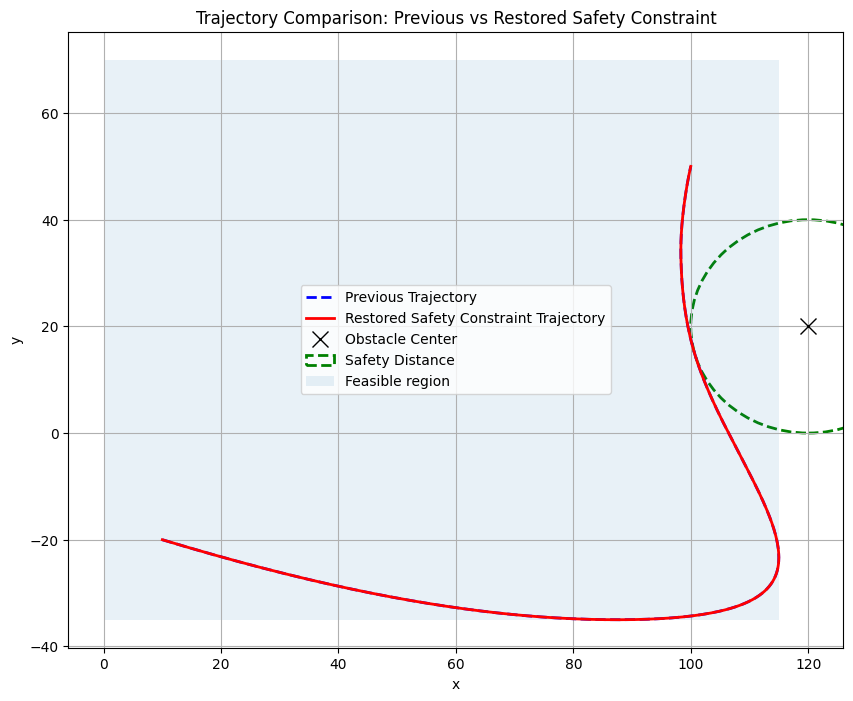

In [185]:
# p_cp_hist의 마지막 궤적 (예시)
p_prev = p_cp_hist[-1]

# 두 궤적 비교하여 시각화
plt.figure(figsize=(10, 8))
plt.plot(p_prev[0, :], p_prev[1, :], 'b--', linewidth=2, label='Previous Trajectory')
plt.plot(p_sol[0, :], p_sol[1, :], 'r-', linewidth=2, label='Restored Safety Constraint Trajectory')
plt.plot(p_obs[0], p_obs[1], 'kx', markersize=12, label='Obstacle Center')
# 장애물 안전 거리를 원으로 표시
circle = plt.Circle((p_obs[0], p_obs[1]), d_sft, color='g', fill=False, linestyle='--', linewidth=2, label='Safety Distance')
plt.gca().add_artist(circle)
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory Comparison: Previous vs Restored Safety Constraint')
plt.legend()
plt.grid(True)
plt.show()

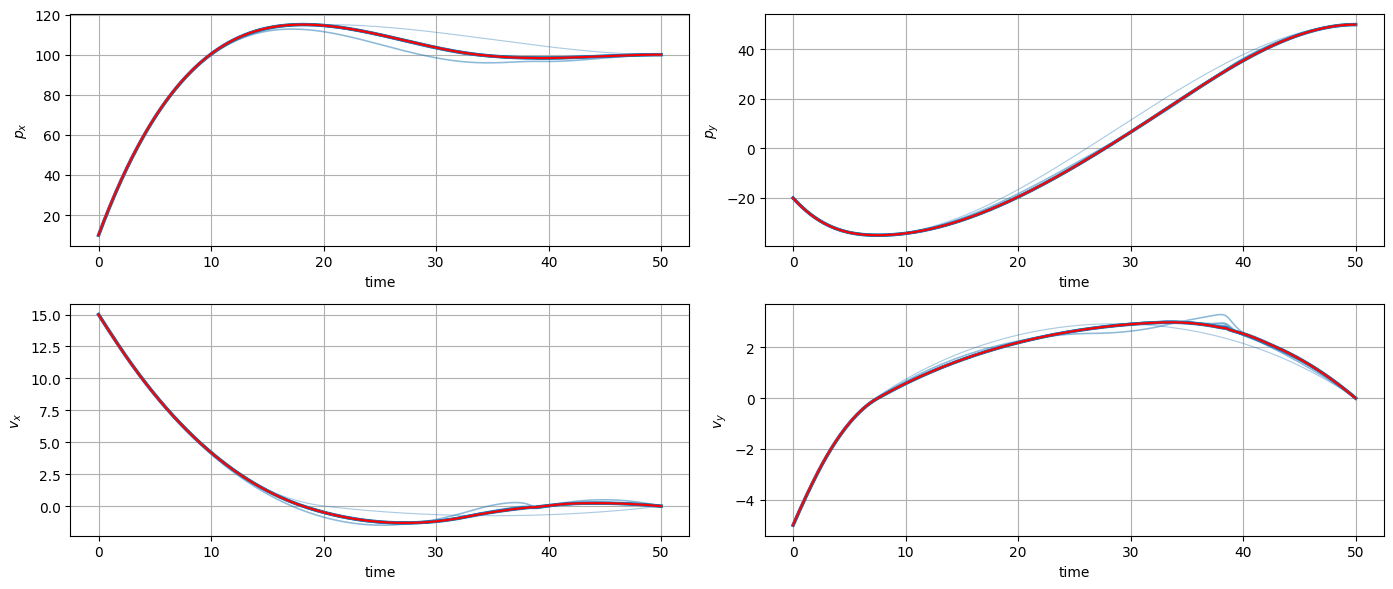

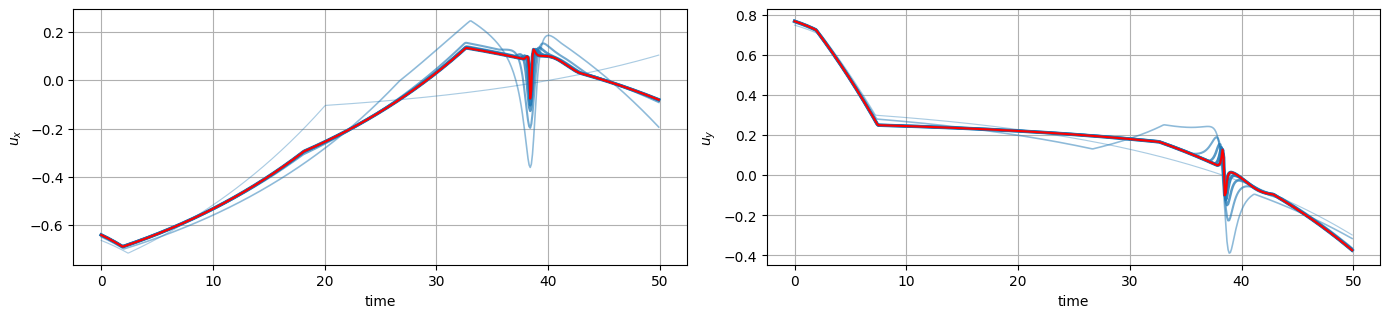

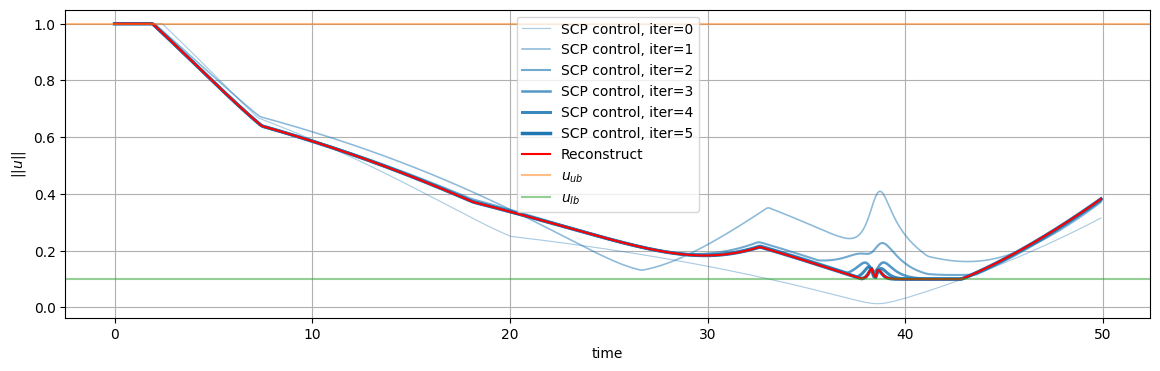

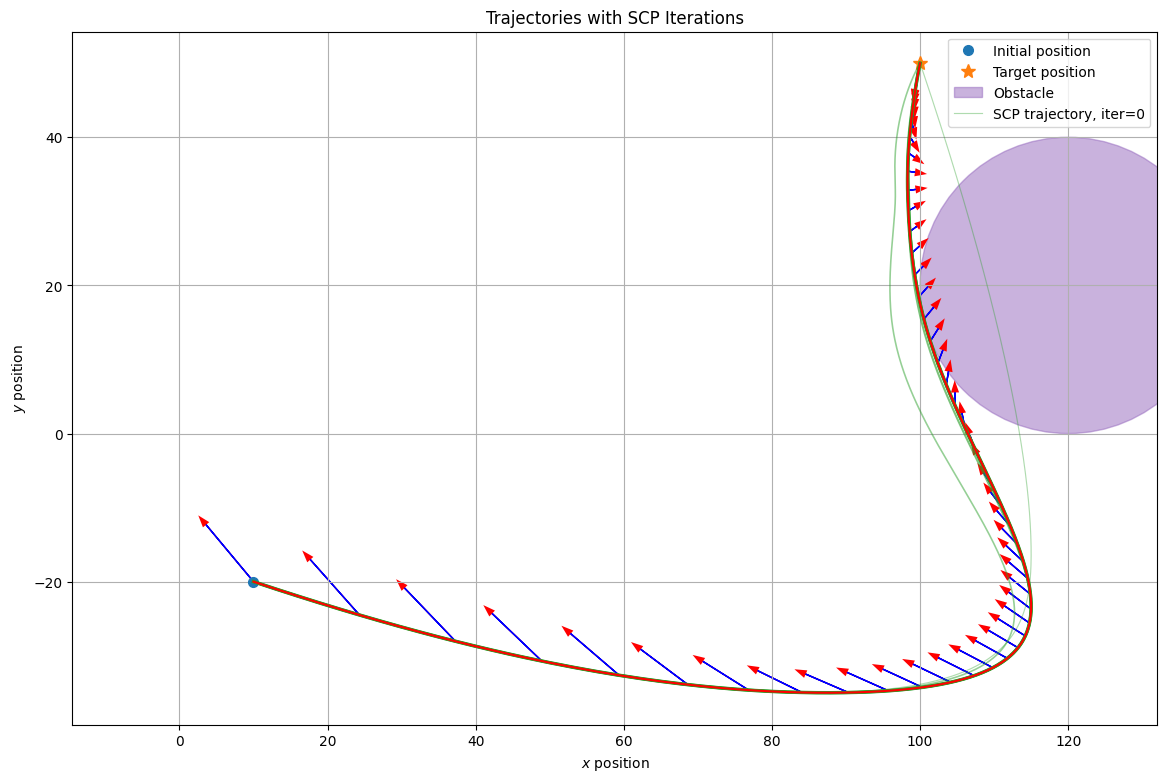

In [186]:
import numpy as np
import matplotlib.pyplot as plt

# 예시 데이터: ts (time vector)와 n_iters, 그리고 p_cp_hist, v_cp_hist, u_cp_hist가 이미 존재한다고 가정
# ts: 시간 축, p_cp_hist: 각 iter에서의 p 해, v_cp_hist: 각 iter에서의 v 해, u_cp_hist: 각 iter에서의 u 해
# n_iters: 총 반복 횟수

# 예시로 아래와 같이 정의 (실제 데이터로 교체하세요)
# 1) p_x, p_y, v_x, v_y 플롯
plt.figure(figsize=(14, 6), dpi=100)

plt.subplot(2, 2, 1)
for id in range(n_iters):
    plt.plot(ts, p_cp_hist[id][0, :], color=plt.cm.tab20(0),
             linewidth=0.5 + (id + 1) / n_iters * 2,
             alpha=(id + 3) / (n_iters + 2))
    plt.plot(ts,p_sol[0,:],color = "red")
plt.xlabel('time')
plt.ylabel(r'$p_x$')
plt.grid()

plt.subplot(2, 2, 2)
for id in range(n_iters):
    plt.plot(ts, p_cp_hist[id][1, :], color=plt.cm.tab20(0),
             linewidth=0.5 + (id + 1) / n_iters * 2,
             alpha=(id + 3) / (n_iters + 2))
    plt.plot(ts,p_sol[1,:],color = "red")
plt.xlabel('time')
plt.ylabel(r'$p_y$')
plt.grid()

plt.subplot(2, 2, 3)
for id in range(n_iters):
    plt.plot(ts, v_cp_hist[id][0, :], color=plt.cm.tab20(0),
             linewidth=0.5 + (id + 1) / n_iters * 2,
             alpha=(id + 3) / (n_iters + 2))
    plt.plot(ts,v_sol[0,:],color = "red")
plt.xlabel('time')
plt.ylabel(r'$v_x$')
plt.grid()

plt.subplot(2, 2, 4)
for id in range(n_iters):
    plt.plot(ts, v_cp_hist[id][1, :], color=plt.cm.tab20(0),
             linewidth=0.5 + (id + 1) / n_iters * 2,
             alpha=(id + 3) / (n_iters + 2))
    plt.plot(ts,v_sol[1,],color = "red")
plt.xlabel('time')
plt.ylabel(r'$v_y$')
plt.grid()

plt.tight_layout()
plt.show()

# 2) u_x, u_y 플롯
plt.figure(figsize=(14, 6), dpi=100)

plt.subplot(2, 2, 1)
for id in range(n_iters):
    plt.plot(ts[:-1], u_cp_hist[id][0, :], color=plt.cm.tab20(0),
             linewidth=0.5 + (id + 1) / n_iters * 2,
             alpha=(id + 3) / (n_iters + 2))
    plt.plot(ts[:-1],u_sol[0,:],color = "red")
plt.xlabel('time')
plt.ylabel(r'$u_x$')
plt.grid()

plt.subplot(2, 2, 2)
for id in range(n_iters):
    plt.plot(ts[:-1], u_cp_hist[id][1, :], color=plt.cm.tab20(0),
             linewidth=0.5 + (id + 1) / n_iters * 2,
             alpha=(id + 3) / (n_iters + 2))
    plt.plot(ts[:-1],u_sol[1,:],color = "red")
plt.xlabel('time')
plt.ylabel(r'$u_y$')
plt.grid()

plt.tight_layout()
plt.show()

# 3) u 노름 플롯
plt.figure(figsize=(14, 4), dpi=100)
for id in range(n_iters):
    control_norm = np.linalg.norm(u_cp_hist[id], axis=0)
    plt.plot(ts[:-1], control_norm, color=plt.cm.tab20(0),
             linewidth=0.5 + (id + 1) / n_iters * 2,
             alpha=(id + 3) / (n_iters + 2),
             label=f'SCP control, iter={id}')

control_norm = np.linalg.norm(u_sol, axis=0)
plt.plot(ts[:-1], control_norm,label='Reconstruct',color = "red")

plt.xlabel('time')
plt.ylabel(r'$||u||$')
plt.axhline(u_ub, color=plt.cm.tab20(2), alpha=0.5, label=r'$u_{ub}$')
plt.axhline(u_lb, color=plt.cm.tab20(4), alpha=0.5, label=r'$u_{lb}$')
plt.legend()
plt.grid()
plt.show()

# 4) 궤적 비교 및 제어 입력 화살표 표시
plt.figure(figsize=(14, 9), dpi=100)
# Feasible region (예: p_lb, p_ub가 스칼라인 경우 영역 표시; p_lb와 p_ub가 벡터인 경우에는 적절히 수정)

plt.plot(p_0[0], p_0[1], 'o', markersize=7, label='Initial position')
plt.plot(p_des[0], p_des[1], '*', markersize=10, label='Target position')
# 장애물와 안전 거리 원 표시 (p_obs와 d_sft)
plt.gca().add_artist(plt.Circle((p_obs[0], p_obs[1]), d_sft,
                                label='Obstacle', color=plt.cm.tab20(8), alpha=0.5))
# 각 반복별 궤적 플롯
for id in range(n_iters):
    plt.plot(p_cp_hist[id][0, :], p_cp_hist[id][1, :],
             color=plt.cm.tab20(4),
             linewidth=0.5 + (id + 1) / n_iters * 2,
             alpha=(id + 3) / (n_iters + 2),
             label=f'SCP trajectory, iter={id}' if id==0 else None)
    plt.plot(p_sol[0,:],p_sol[1,:],color = "red")

# 최종 반복의 궤적에 제어 입력 방향 화살표 표시 (예: 매 10번 샘플링)
for t in range(0, N, 10):
    plt.arrow(p_cp_hist[-1][0, t], p_cp_hist[-1][1, t],
              10 * u_cp_hist[-1][0, t], 10 * u_cp_hist[-1][1, t],
              head_width=1.1, width=0.2, color='r', ec='none')
    plt.arrow(p_sol[0,t],p_sol[1,t],10*u_sol[0,t], 10*u_sol[1,t]   , color = "blue")
plt.legend()
plt.title('Trajectories with SCP Iterations')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()


Iteration 1: ||p_sol - p_ref||_F = 0.2623
Converged at iteration 2


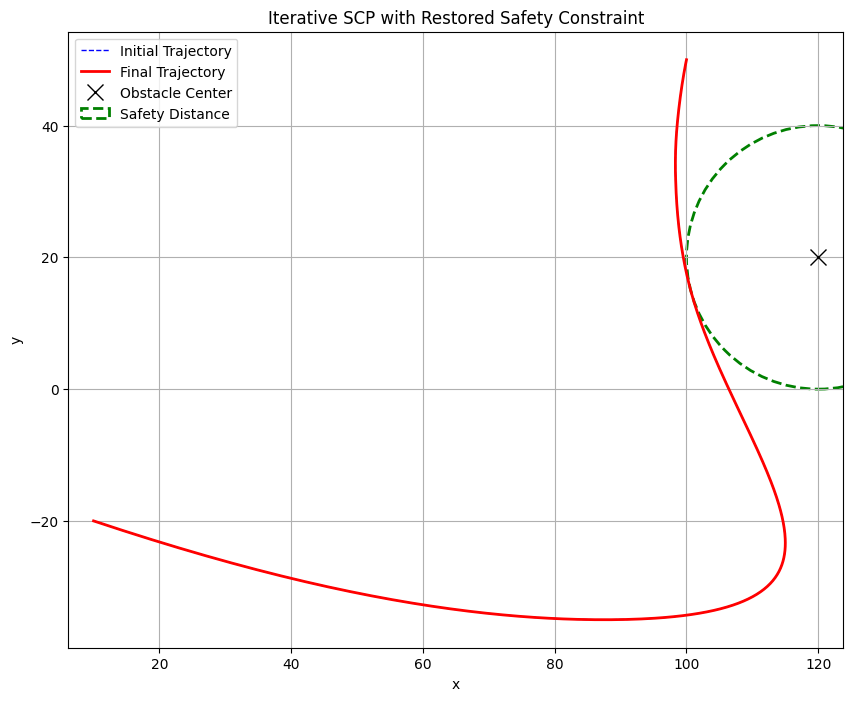

In [187]:


# 반복 저장을 위한 리스트
p_cp_hist = [p_sol]
u_cp_hist = [u_sol]

max_iters = 10
tol = 1e-1  # 수렴 판정 기준 (Frobenius norm)

for k in range(max_iters):
    # 이전 해를 참조 궤적으로 사용
    p_ref = p_cp_hist[-1]
    u_ref = u_cp_hist[-1]

    # 최적화 변수 선언
    p = cp.Variable((2, N+1))
    v = cp.Variable((2, N+1))
    u = cp.Variable((2, N))

    # 목적 함수: 제어 입력의 2-노름 제곱의 합 최소화
    obj = cp.Minimize(cp.sum_squares(u))

    # 경계 조건 및 동역학 제약조건 추가
    constr = [ p[:, 0] == p_0, p[:, -1] == p_des,
               v[:, 0] == v_0, v[:, -1] == v_des ]

    for t in range(N):
        constr += [ v[:, t+1] == (1 - gamma * delt) * v[:, t] + delt * u[:, t] ]
        constr += [ p[:, t+1] == p[:, t] + delt * (1 - 0.5 * gamma * delt) * v[:, t] + 0.5 * delt**2 * u[:, t] ]
        constr += [ p_lb <= p[:, t+1], p[:, t+1] <= p_ub ]
        constr += [ cp.norm(u[:, t]) <= u_ub ]
        # safety constraint 복원: 해당 시간 단계에서 활성으로 라벨된 경우, 선형화된 제약 조건을 추가
        if active_labels[t]['safety_constraint_active']:
            constr += [ 2 * (p_ref[:, t] - p_obs).T @ p[:, t]
                        >= d_sft**2 + np.sum(p_ref[:, t]**2) - np.sum(p_obs**2) ]
        if active_labels[t]['control_lb_constraint_active']:
            constr += [ 2*u0[:,t].T@u[:,t] >= u_lb**2 + u0[:,t].dot(u0[:,t]) ]
    prob = cp.Problem(obj, constr)
    prob.solve(verbose=False)

    p_sol = p.value
    u_sol = u.value

    p_cp_hist.append(p_sol)
    u_cp_hist.append(u_sol)

    # 수렴 판정: 이전 해와 새로운 해 사이의 차이가 tol 이하이면 종료
    if np.linalg.norm(p_sol - p_ref, 'fro') < tol:
        print(f'Converged at iteration {k+1}')
        break
    else:
        print(f'Iteration {k+1}: ||p_sol - p_ref||_F = {np.linalg.norm(p_sol - p_ref, "fro"):.4f}')

# 반복 종료 후 최종 해 p_sol, u_sol
# 최종 해 시각화 (예: 궤적)
plt.figure(figsize=(10, 8))
plt.plot(p_cp_hist[0][0, :], p_cp_hist[0][1, :], 'b--', linewidth=1, label='Initial Trajectory')
plt.plot(p_sol[0, :], p_sol[1, :], 'r-', linewidth=2, label='Final Trajectory')
plt.plot(p_obs[0], p_obs[1], 'kx', markersize=12, label='Obstacle Center')
circle = plt.Circle((p_obs[0], p_obs[1]), d_sft, color='g', fill=False, linestyle='--', linewidth=2, label='Safety Distance')
plt.gca().add_artist(circle)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Iterative SCP with Restored Safety Constraint')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()